In [1]:
# add path to sispeuede to sys.path in python
import sys
import warnings
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)


warnings.filterwarnings("ignore")

import logging
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede as si
import sisepuede.core.attribute_table as att
import sisepuede.core.model_attributes as ma
import sisepuede.core.model_variable as mv
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_examples as sxm
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.plotting.plots as spp
import sisepuede.transformers as trf
import sisepuede.utilities._toolbox as sf
import time
from typing import *

# hack for now
log_job = None



# Setup the file structure and read in data

In [2]:
struct = sfs.SISEPUEDEFileStructure()
examples = sxm.SISEPUEDEExamples()

matt = struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# directories
path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")
if not path_transformations.exists():
    path_transformations.mkdir(exist_ok = True, )

# file paths
fp_inputs = path_data.joinpath("louisiana_inputs_raw.csv")#joinpath("louisiana_working_data_20240826", "MODEL_INPUTS.csv")



##  Format input data

In [3]:
# read in default data
regions_run = ["louisiana"]
df_inputs_base_la = pd.read_csv(fp_inputs, )
df_input = df_inputs_base_la.copy()


# overwrite some variables
for mvname in ["Agriculture Equivalent Exports", "Livestock Equivalent Exports"]:
    modvar = matt.get_variable(mvname)
    if modvar is None:
        raise RuntimeError(f"Error: model variable '{mvname}' not found.")
    df_input[modvar.fields] = 0


# filter
field_region = regions.key
regions_run = [
    x for x in regions_run if x in list(df_input[field_region].unique())
]

# reduce inputs
df_input = (
    df_input[
        df_input[field_region].isin(regions_run)
    ]
    #.drop(columns = [matt.dim_primary_id])
    .reset_index(drop = True)
)





In [601]:
"""for fld in [
    "ef_soil_c_croplands_drained_organic_temperate_crop_grass_tonne_per_ha",
    "ef_soil_c_croplands_drained_organic_tropical_crop_grass_tonne_per_ha",
    "ef_soil_c_managed_grasslands_drained_organic_temperate_crop_grass_tonne_per_ha",
    "ef_soil_c_managed_grasslands_drained_organic_tropical_crop_grass_tonne_per_ha"
]:
    df_input[fld] = float(df_examples[fld].iloc[0])

# put a small amount
df_input["frac_lndu_initial_with_drained_organic_soils_croplands"] = 0.01
df_input["frac_lndu_initial_with_drained_organic_soils_pastures"] = 0.01"""


df_input.to_csv(
    path_data.joinpath("louisiana_inputs_raw.csv"),
    encoding = "UTF-8",
    index = None,
)

In [5]:
[x for x in matt.all_variable_fields_input if x not in df_input.columns]

[]

###  Secondary attempt - run if everything is built

In [4]:
df_input = pd.read_csv(path_data.joinpath("louisiana_inputs_raw.csv"))


# build transformations

In [5]:
transformers = trf.Transformers(
    {},
    df_input = df_input,
)

if not path_transformations.exists():
    
    print("BUILDING DEFAULT TRANSFORMATIONS")
    
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )


# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    path_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table


# build strategies
import sisepuede.transformers.strategies as sts
importlib.reload(sts)
#  build the strategies -- will export to path
t0 = time.time()
strategies = sts.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

# build whirlpool with existing data
# tss = strategies.build_whirlpool_strategies(6004, ids = list(range(7101, 7160)))


##  GET XL SPECIFICATIONS AND SAMPLE GROUPS

# base off of the LA strat
strat = strategies.get_strategy(6004)

transformations_include = strat.get_transformation_list(
    strat.transformation_specification,
    transformations,
)

_FIELD_VARIABLE = "variable"
_FIELD_VARIABLE_TRAJECTORY_GROUP = "variable_trajectory_group"

df_transformation_code_to_varchange = transformations.get_transformations_variable_fields(
    transformations_include = transformations_include,
    include_all_variable_fields_by_modvar = False, 
    include_sample_group = True,
    field_sample_group = _FIELD_VARIABLE_TRAJECTORY_GROUP,
    field_variable = _FIELD_VARIABLE,
)


# HEREHEREHERE


Strategies defined at /Users/usuario/git/sisepuede_region_nbs/louisiana/transformations initialized in 3.9 seconds


# Build uncertainty ranges that we want for an experiment
- initialize `_GROUP_IND_UNCERTAINTY` iterator below

In [6]:
strat = strategies.get_strategy(6004)

In [147]:
_DF_UNCERTAINTY = []
_GROUP_IND_UNCERTAINTY = 1


tp_max = max(time_periods.all_time_periods)

_FIELD_MAX = f"max_{tp_max}"
_FIELD_MIN = f"min_{tp_max}"
_FIELD_TRAJGROUP = strategies.input_template.field_req_variable_trajectory_group
_FIELD_VARIABLE = strategies.input_template.field_req_variable



##  Build uncertainties for fuel prices

In [148]:

_CATS_ENFU_FF = [
    "fuel_coal",
    "fuel_coke",
    "fuel_crude",
    "fuel_diesel",
    "fuel_gasoline",
    "fuel_hydrocarbon_gas_liquids",
    "fuel_kerosene",
    "fuel_natural_gas",
    "fuel_oil"
]
scalar_range = (0.5, 1.5)


# variables to tie into groups
modvar_fuel_price_gravimetric = matt.get_variable("Gravimetric Fuel Price")
modvar_fuel_price_thermal = matt.get_variable("Thermal Fuel Price")
modvar_fuel_price_volumetric = matt.get_variable("Volumetric Fuel Price")
modvars = [
    modvar_fuel_price_gravimetric,
    modvar_fuel_price_thermal,
    modvar_fuel_price_volumetric
]

fields_combine = []
for mv in modvars:
    fields_combine += mv.build_fields(
        category_restrictions = _CATS_ENFU_FF
    )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [scalar_range[1] for x in fields_combine],
        _FIELD_MIN: [scalar_range[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1
df_component


,variable,max_35,min_35,variable_trajectory_group
0,cost_enfu_fuel_coal_usd_per_tonne,1.5,0.5,1
1,cost_enfu_fuel_coke_usd_per_tonne,1.5,0.5,1
2,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per...,1.5,0.5,1
3,cost_enfu_fuel_natural_gas_usd_per_mmbtu,1.5,0.5,1
4,cost_enfu_fuel_crude_usd_per_m3,1.5,0.5,1
5,cost_enfu_fuel_diesel_usd_per_m3,1.5,0.5,1
6,cost_enfu_fuel_gasoline_usd_per_m3,1.5,0.5,1
7,cost_enfu_fuel_kerosene_usd_per_m3,1.5,0.5,1
8,cost_enfu_fuel_oil_usd_per_m3,1.5,0.5,1


In [149]:
'/Users/usuario/Desktop/attributes'

'/Users/usuario/Desktop/attributes'

## Build uncertainties for power techs

In [150]:

dict_tech_classes = transformers.model_enerprod.get_tech_info_dict()
_CATS_ETNC_PP = dict_tech_classes.get("all_techs_pp")

groups = [
    [
        "pp_coal",
        "pp_coal_ccs",
        "pp_gas",
        "pp_gas_ccs",
        "pp_oil"
    ],
    [
        "pp_nuclear"
    ]
]

scalar_ranges = [(0.75, 1.25), (0.75, 1.5)]


# variables to tie into groups
modvar_capex = matt.get_variable("NemoMod CapitalCost")
modvar_fixed = matt.get_variable("NemoMod FixedCost")
modvar_variable = matt.get_variable("NemoMod VariableCost")

for i, grp in enumerate(groups):

    # group the model variables together
    for modvar in [
        modvar_capex,
        modvar_fixed,
        modvar_variable
    ]:
    
        ranges = scalar_ranges[i]
        fields_combine = modvar.build_fields(category_restrictions = grp, )
        
        
        df_component = pd.DataFrame(
            {
                _FIELD_VARIABLE: fields_combine,
                _FIELD_MAX: [ranges[1] for x in fields_combine],
                _FIELD_MIN: [ranges[0] for x in fields_combine],
                _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
            }
        )
    
        _DF_UNCERTAINTY.append(df_component)
    
    _GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,nemomod_entc_variable_cost_pp_nuclear_usd_per_mwh,1.5,0.75,3


##  Build uncertainties for energy storage

In [158]:

# variables to tie into groups
modvar_capex = matt.get_variable("NemoMod CapitalCostStorage")
ranges = (0.8, 1.2)
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,nemomod_enst_capital_cost_st_batteries_usd_per...,1.2,0.8,4
1,nemomod_enst_capital_cost_st_compressed_air_us...,1.2,0.8,4
2,nemomod_enst_capital_cost_st_flywheels_usd_per...,1.2,0.8,4
3,nemomod_enst_capital_cost_st_pumped_hydro_usd_...,1.2,0.8,4


##  Build uncertainties for fuel exports

In [159]:

scalar_ranges = (0.75, 1.75)


# variables to tie into groups
modvar_capex = matt.get_variable("Fuel Exports")
ranges = scalar_ranges
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,exports_enfu_pj_fuel_ammonia,1.75,0.75,5
1,exports_enfu_pj_fuel_coal,1.75,0.75,5
2,exports_enfu_pj_fuel_crude,1.75,0.75,5
3,exports_enfu_pj_fuel_diesel,1.75,0.75,5
4,exports_enfu_pj_fuel_electricity,1.75,0.75,5
5,exports_enfu_pj_fuel_gasoline,1.75,0.75,5
6,exports_enfu_pj_fuel_hydrocarbon_gas_liquids,1.75,0.75,5
7,exports_enfu_pj_fuel_hydrogen,1.75,0.75,5
8,exports_enfu_pj_fuel_kerosene,1.75,0.75,5
9,exports_enfu_pj_fuel_natural_gas,1.75,0.75,5


##  Build Uncertainties for GDP

In [160]:

scalar_ranges = (0.9, 1.1)


# variables to tie into groups
modvar_capex = matt.get_variable("GDP")
ranges = scalar_ranges
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,gdp_mmm_usd,1.1,0.9,6


##  Build uncertainties for population

In [162]:

scalar_ranges = (0.925, 1.075)


# variables to tie into groups
modvar_capex = matt.get_variable("Population")
ranges = scalar_ranges
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,population_gnrl_rural,1.075,0.925,7
1,population_gnrl_urban,1.075,0.925,7


##  Build uncertainties for SCOE elasticities

In [163]:
modvars = [
    "SCOE Elasticity of Per GDP Electrical Applicance Demand to GDP Per Capita",
    "SCOE Elasticity of Per GDP Heat Energy Demand to GDP Per Capita",
	"SCOE Elasticity of Per Household Electrical Applicance Demand to GDP Per Capita",
	"SCOE Elasticity of Per Household Heat Energy Demand to GDP Per Capita"
]



scalar_ranges = (0.75, 1.25)


# variables to tie into groups

for x in modvars:
    modvar = matt.get_variable(x)
    ranges = scalar_ranges
    fields_combine = modvar.fields#build_fields(category_restrictions = grp, )
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    _DF_UNCERTAINTY.append(df_component)

_GROUP_IND_UNCERTAINTY += 1



##  Build uncertainties for Transportation Elasticities

In [164]:
modvars = [
    "Elasticity of Megatonne-Kilometer Demand to GDP",
    "Elasticity of Passenger-Kilometer Demand per Capita to GDP per Capita"
]



scalar_ranges = (0.75, 1.25)


# variables to tie into groups

for x in modvars:
    modvar = matt.get_variable(x)
    ranges = scalar_ranges
    fields_combine = modvar.fields#build_fields(category_restrictions = grp, )
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    # inentionally separate the groupings
    _DF_UNCERTAINTY.append(df_component)
    _GROUP_IND_UNCERTAINTY += 1



##  Build uncertainties for INEN Elasticities

In [165]:
modvars = [
    "Elasticity of Industrial Production to GDP",
    "Elasticity of Product Use Rate to GDP per Capita",
]



scalar_ranges = (0.75, 1.25)


# variables to tie into groups

for x in modvars:
    modvar = matt.get_variable(x)
    ranges = scalar_ranges
    fields_combine = modvar.fields
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    _DF_UNCERTAINTY.append(df_component)
    _GROUP_IND_UNCERTAINTY += 1



In [166]:
_DF_UNCERTAINTY = sf._concat_df(_DF_UNCERTAINTY)

In [167]:
_DF_UNCERTAINTY

,variable,max_35,min_35,variable_trajectory_group
0,cost_enfu_fuel_coal_usd_per_tonne,1.50,0.50,1
1,cost_enfu_fuel_coke_usd_per_tonne,1.50,0.50,1
2,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per...,1.50,0.50,1
3,cost_enfu_fuel_natural_gas_usd_per_mmbtu,1.50,0.50,1
4,cost_enfu_fuel_crude_usd_per_m3,1.50,0.50,1
...,...,...,...,...
66,elasticity_ippu_wood_production_to_gdp,1.25,0.75,11
67,elasticity_ippu_product_use_lubricants_product...,1.25,0.75,12
68,elasticity_ippu_product_use_ods_other_product_...,1.25,0.75,12
69,elasticity_ippu_product_use_ods_refrigeration_...,1.25,0.75,12


##  Build the `trajgroups` input

In [168]:
df_trajgroups = (
    df_transformation_code_to_varchange
    .get(
        [
            "variable_field",
            _FIELD_TRAJGROUP
        ]
    )
    .copy()
    .drop_duplicates()
    .reset_index(drop = True, )
    .rename(columns = {"variable_field": _FIELD_VARIABLE, })
)

df_uncertainty_component = _DF_UNCERTAINTY[[_FIELD_VARIABLE, _FIELD_TRAJGROUP]]
df_uncertainty_component[_FIELD_TRAJGROUP] += df_trajgroups[_FIELD_TRAJGROUP].max()

# check that there are no overlapping fields
shared_vfs = set(df_trajgroups[_FIELD_VARIABLE]) & set(df_uncertainty_component[_FIELD_VARIABLE])
if len(shared_vfs) > 0:
    raise RuntimeError("Cannot have overlapping fields in this merge")

df_trajgroups = sf._concat_df(
    [
        df_trajgroups,
        df_uncertainty_component,
    ]
)



In [707]:
#_DF_UNCERTAINTY


In [169]:
df_transformation_code_to_varchange

,transformation_code,variable,variable_field,variable_trajectory_group
0,TX:AGRC:DEC_CH4_RICE,:math:\text{CH}_4 Crop Anaerobic Decomposition...,ef_agrc_anaerobicdom_rice_kg_ch4_ha,1
1,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,Fraction of Food Produced Lost Before Consumption,frac_agrc_agriculture_production_lost,2
2,TX:AGRC:INC_CONSERVATION_AGRICULTURE,Fraction of Residues Burned,frac_agrc_crop_residues_burned,3
3,TX:AGRC:INC_CONSERVATION_AGRICULTURE,Fraction of Residues Removed,frac_agrc_crop_residues_removed,3
4,TX:AGRC:INC_CONSERVATION_AGRICULTURE,No Till Crop Fraction,frac_agrc_no_till_cereals,3
...,...,...,...,...
462,TX:WASO:INC_RECYCLING,Fraction of Waste Recycled,frac_waso_recycled_paper,46
463,TX:WASO:INC_RECYCLING,Fraction of Waste Recycled,frac_waso_recycled_plastic,46
464,TX:WASO:INC_RECYCLING,Fraction of Waste Recycled,frac_waso_recycled_rubber_leather,46
465,TX:WASO:INC_RECYCLING,Fraction of Waste Recycled,frac_waso_recycled_textiles,46


In [182]:
path_out = pathlib.Path("/Users/usuario/Documents/Projects/Louisiana/experiments/attributes_and_info/sisepuede_run_2025-08-28T15;29;22.344855")
if not path_out.is_dir():
    path_out.mkdir(exist_ok = True, )
    
df_transformation_code_to_varchange.to_csv(
    path_out.joinpath("VARIABLE_TRAJECTORY_GROUPS_L.csv"),
    index = None,
    encoding = "UTF-8",
)

df_uncertainty_component.to_csv(
    path_out.joinpath("VARIABLE_TRAJECTORY_GROUPS_X.csv"),
    index = None,
    encoding = "UTF-8",
)

# START--build low implementation strategy configs

In [170]:
strat = strategies.get_strategy(6004)
transformations_list_all_la = strat.get_transformation_list(
    strat.transformation_specification,
    strategies.transformations,
)



In [507]:
def copy_to_medium_intensity(
    transformations: 'Transformations',
    all_codes: List[str],
    export: bool = False,
    key_magnitude: str = "magnitude",
    key_tp0: str = "tp_0_ramp",
    key_vir: str = "vec_implementation_ramp",
    verbose: bool = True,
) -> None:
    """Copy NDC transformations to NDC 2.0 with time starting in 2020
    """
    paths_transformations_cur = transformations.dict_paths.get(
        transformations.key_path_transformations, 
    )

    all_codes_out = []

    # iterate over each path
    for path in paths_transformations_cur:

        # get and check the code associated with this YAML
        transformation = trf.Transformation(
            path,
            transformations.transformers,
        )
        
        # skip any non-ndc transformations
        if transformation.code not in all_codes:
            continue


        ##  SET OUTPUT PATH AND EXPORT
        
        path_out = path.stem
        append = "_MIDINTENS"
        path_out = f"{path_out}{append}{path.suffix}"
        path_out = path.parents[0].joinpath(path_out)
        

        ##  UPDATE YAML - START WITH MAGNITUDE
            
        # get the parameters and update the start time
        dict_yaml = sf.read_yaml(path, munchify_dict = False, )
        dict_params = dict_yaml.get(transformation.key_parameters, )

        # get the magnitude from parameters and update as necessary
        mag = dict_params.get(key_magnitude)
        if mag is not None:
            dict_params.update({key_magnitude: mag/2, })
            if verbose: print(f"{transformation.code} magnitude updated successfully.")

        elif verbose: 
            print(f"\tNO MAGNITUDE: check {transformation.code} at '{path_out}'")
 
        dict_yaml.update({transformation.key_parameters: dict_params, })


        ##  UPDATE IDENTIFICATION INFO
        
        dict_ids = dict_yaml.get(transformation.key_identifiers, )

        # update the code
        code = dict_ids.get(transformation.key_transformation_code, )
        code = f"{code}{append}"
        dict_ids.update({transformation.key_transformation_code: code, })

        # update the name
        name = dict_ids.get(transformation.key_transformation_name, )
        name = f"{name} at medium intensity for jobs run"
        dict_ids.update({transformation.key_transformation_name: name, })

        dict_yaml.update({transformation.key_identifiers: dict_ids, })

        
        
        # write output?
        if export: sf._write_yaml(dict_yaml, path_out, )

        # finally, add to all codes to build new strategy
        all_codes_out.append(code)

    
    all_codes_out.sort()

    return all_codes_out





# already exported, no need to do it again at the moment
all_codes_mid = copy_to_medium_intensity(
    transformations, 
    [x.code for x in transformations_list_all_la],
    export = False, 
    verbose = False,
);

all_codes_mid_build = [
    x for x in all_codes_mid 
    if x not in ["TX:PFLO:INC_HEALTHIER_DIETS_MIDINTENS", "TX:ENTC:LEAST_COST_SOLUTION_MIDINTENS"]
]



##  Add in strategies for sub-subsector groupings in energy from Alison


In [655]:
df_transformation_groupings = pd.read_excel(
    path_transformations.joinpath("TWI_20250814_Table_Sector Transformation Groups.xlsx"),
    sheet_name = None,
)


df_definitions = (
    df_transformation_groupings.get("LEAP Run List")
    .drop(columns = "Unnamed: 1")
    .iloc[1:]
)

_FIELD_RUNS = "Runs:"
fields_strats = [x for x in df_definitions.columns if x not in [_FIELD_RUNS]]

# convert the strategy columns to a name and code
def column_to_code_name(
    col_name: str,
) -> Tuple[str, str]:
    """Using a column name, convert to code, name tuple
    """

    col_name = (
        col_name
        .replace("T&B", "Transport and Buildings")
        .replace("&", "and")
    )
    
    name = f"TWI energy Subsector {col_name}"
    code = (
        col_name
        .upper()
        .replace(" ", "_")
    )
    code = f"PFLO:TWI_{code}"

    out = (code, name, )

    return out


# get info in a dict
dict_strats_twi = {}

def clean_transformation(
    tr_name: str,
) -> str:
    """Clean the transformation string
    """
    out = tr_name.split()[1]
    return out





strategy_id_new = max(strategies.all_strategies) + 1
df_out = []
delim = "|"
for fld in fields_strats:
    code, name = column_to_code_name(fld, )

    df_filt = (
        df_definitions[[_FIELD_RUNS, fld]]
        .dropna()
    )

    transformations_out = delim.join(
        sorted(
            list(
                df_filt[_FIELD_RUNS]
                .apply(clean_transformation, )
            )
        )
    )

    row_new = [
        strategy_id_new,
        code,
        name,
        f"Defined by TWI 20250814 - {name}",
        transformations_out,
        0
    ]

    df_out.append(row_new)
    strategy_id_new += 1



cols_new = [
    strategies.key_strategy,
    strategies.field_strategy_code,
    strategies.field_strategy_name,
    strategies.field_description,
    strategies.field_transformation_specification,
    strategies.field_baseline_strategy
]

df_out = pd.DataFrame(
    df_out,
    columns = cols_new,
)


In [656]:

# get the current table
tab = strategies.attribute_table.table
tab = tab[
    ~tab[strategies.key_strategy].isin([_STRAT_ID_NEW])
]

tab = (
    pd.concat(
        [
            tab,
            df_out
        ],
        axis = 0,
    )
    .sort_values(by = [strategies.key_strategy])
    .reset_index(drop = True, )
)

In [658]:
# export?
if True:
    tab.to_csv(
        strategies.path_strategy_definition,
        encoding = "UTF-8",
        index = None,
    )





In [732]:
_STRAT_ID_NEW = 6005

# get the current table
tab = strategies.attribute_table.table
tab = tab[
    ~tab[strategies.key_strategy].isin([_STRAT_ID_NEW])
]

# add a new row
row_new = {
    strategies.key_strategy: _STRAT_ID_NEW,
    strategies.field_strategy_code: "PFLO:ALL_LA_ACTIONS_MEDIUM_INTENSITY",
    strategies.field_strategy_name: "All Louisiana Actions at medium (approx 50%) intensity",
    strategies.field_description: "Includes all actions evaluate in LEAP, but with lower intensity of implementation.", 
    strategies.field_transformation_specification: "|".join(all_codes_mid_build),
    strategies.field_baseline_strategy: 0
}

tab = (
    pd.concat(
        [
            tab,
            pd.DataFrame(pd.Series(row_new)).transpose(),
        ],
        axis = 0,
    )
    .sort_values(by = [strategies.key_strategy])
    .reset_index(drop = True, )
)

# export?
if True:
    tab.to_csv(
        strategies.path_strategy_definition,
        encoding = "UTF-8",
        index = None,
    )

## Build the strategies to templates (include default variable trajectory groups)

In [172]:


strategies.build_strategies_to_templates(
    df_trajgroup = df_trajgroups,
    df_variable_info = _DF_UNCERTAINTY[[_FIELD_VARIABLE, _FIELD_MIN, _FIELD_MAX]],
    dict_variable_missing_val = {
        _FIELD_MIN: 1.0,
        _FIELD_MAX: 1.0,
    },
    include_simplex_group_as_trajgroup = False,
    strategies = [0] + list(range(6004, 6017)),#strategies.all_strategies,#list(range(7101, 7160)),#[0, 6003, 6004, 6005] #+ list(range(7001, 7062)), # list(range(7101, 7160))
)




0

In [8]:
strategies.get_strategy(6016).name

'TWI energy Subsector Full LEAP Set LC'

# Run the model


In [9]:

ssp = si.SISEPUEDE(
    "calibrated",
    #attribute_time_period = attr_time_period,
    db_type = "csv", # must run as a CSV for now
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    logger = log_job,
    random_seed = 446182,
    regions = ["louisiana"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = False,
)

log_job = ssp.logger


2025-09-01 18:38:54,488 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-09-01 18:38:54,489 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-09-01 18:38:54,489 - INFO - 	Setting export engine to 'csv'.
2025-09-01 18:38:54,490 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-09-01 18:38:54,490 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-09-01 18:38:54,490 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-09-01 18:38:54,490 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-09-01 18:38:54,491 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-09-01 18:38:54,491 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-09-01 18:38:54,491 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1946.5 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-09-01 18:39:33,101 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-09-01 18:39:33,116 - INFO - Successfully initialized SISEPUEDEModels.
2025-09-01 18:39:33,123 - INFO - Table ANALYSIS_METADATA successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_ru

# Check the design id--here's where we'll leverage it
- `design_id` controls what variables vary where; we'll vary the effects only
- as of the latest run (20250114), `design_id 3` varies lever effects (LEs) only between 10% and 100% of implementation

In [284]:
"""att = matt.get_dimensional_attribute_table(matt.dim_design_id)
tab = att.table
dict_append = {
    ssp.key_design: [4],
    "vary_l": [1],
    "vary_x": [1],
    "linear_transform_l_m": [1.0],
    "linear_transform_l_b": [0.0],
    "linear_transform_l_inf": [0.0],
    "linear_transform_l_sup": [1.0],
    "design_name": ["Vary Xs and LEs with full range of LE"],
    "include": [1]
}

tab_new = pd.concat([tab, pd.DataFrame(dict_append)])
tab_new.to_csv(
    att.fp_table,
    encoding = "UTF-8",
    index = None,
)
"""
matt.get_dimensional_attribute_table(matt.dim_design_id)

,design_id,vary_l,vary_x,linear_transform_l_m,linear_transform_l_b,linear_transform_l_inf,linear_transform_l_sup,design_name,include
0,0,0,1,1.00,0.00,1.00,1,Vary Xs (design 0),1
1,1,1,1,0.75,0.25,0.25,1,Vary Xs and Les; Cap LE at 1 (design 1),1
2,2,1,1,1.25,0.00,0.25,1,"Vary Xs and LEs; Cap LE at 1.1 (design 2, 20% ...",1
3,3,1,0,0.90,0.10,0.10,1,Vary LEs; (design 3),1


In [438]:
"""#lhs_design.fields_vary_l
#dir(lhs_design)
lhs_design.arr_lhs_l.shape
df_out = pd.DataFrame(
    lhs_design.arr_lhs_l,
)
df_out.columns = lhs_design.fields_factors_l
df_out["future_id"] = range(1, df_out.shape[0] + 1)

df_out.to_csv("/Users/usuario/Desktop/lhs_sample_group_experiments.csv", index = None, encoding = "UTF-8")
"""

'#lhs_design.fields_vary_l\n#dir(lhs_design)\nlhs_design.arr_lhs_l.shape\ndf_out = pd.DataFrame(\n    lhs_design.arr_lhs_l,\n)\ndf_out.columns = lhs_design.fields_factors_l\ndf_out["future_id"] = range(1, df_out.shape[0] + 1)\n\ndf_out.to_csv("/Users/usuario/Desktop/lhs_sample_group_experiments.csv", index = None, encoding = "UTF-8")\n'

###   Since we didn't specify it, we'll run the config default # of samples

In [439]:
dir(ssp.experimental_manager.dict_lhs_design.get("louisiana"))

lhs_design = ssp.experimental_manager.dict_lhs_design.get("louisiana")




##  Run the model here
- will specify `strategy_id` associated with All Actions and `design_id = 3`
- do not specify `future_id` because we are running across all available futures

2025-08-06 12:27:57,234 - INFO - Running AFOLU model
2025-08-06 12:27:57,234 - INFO - Running AFOLU model
2025-08-06 12:27:57,552 - INFO - AFOLU model run successfully completed
2025-08-06 12:27:57,552 - INFO - AFOLU model run successfully completed
2025-08-06 12:27:57,552 - INFO - Running CircularEconomy model
2025-08-06 12:27:57,552 - INFO - Running CircularEconomy model
2025-08-06 12:27:57,581 - INFO - CircularEconomy model run successfully completed
2025-08-06 12:27:57,581 - INFO - CircularEconomy model run successfully completed
2025-08-06 12:27:57,581 - INFO - Running IPPU model
2025-08-06 12:27:57,581 - INFO - Running IPPU model
2025-08-06 12:27:57,629 - INFO - IPPU model run successfully completed
2025-08-06 12:27:57,629 - INFO - IPPU model run successfully completed
2025-08-06 12:27:57,630 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-06 12:27:57,630 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-06 1

(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

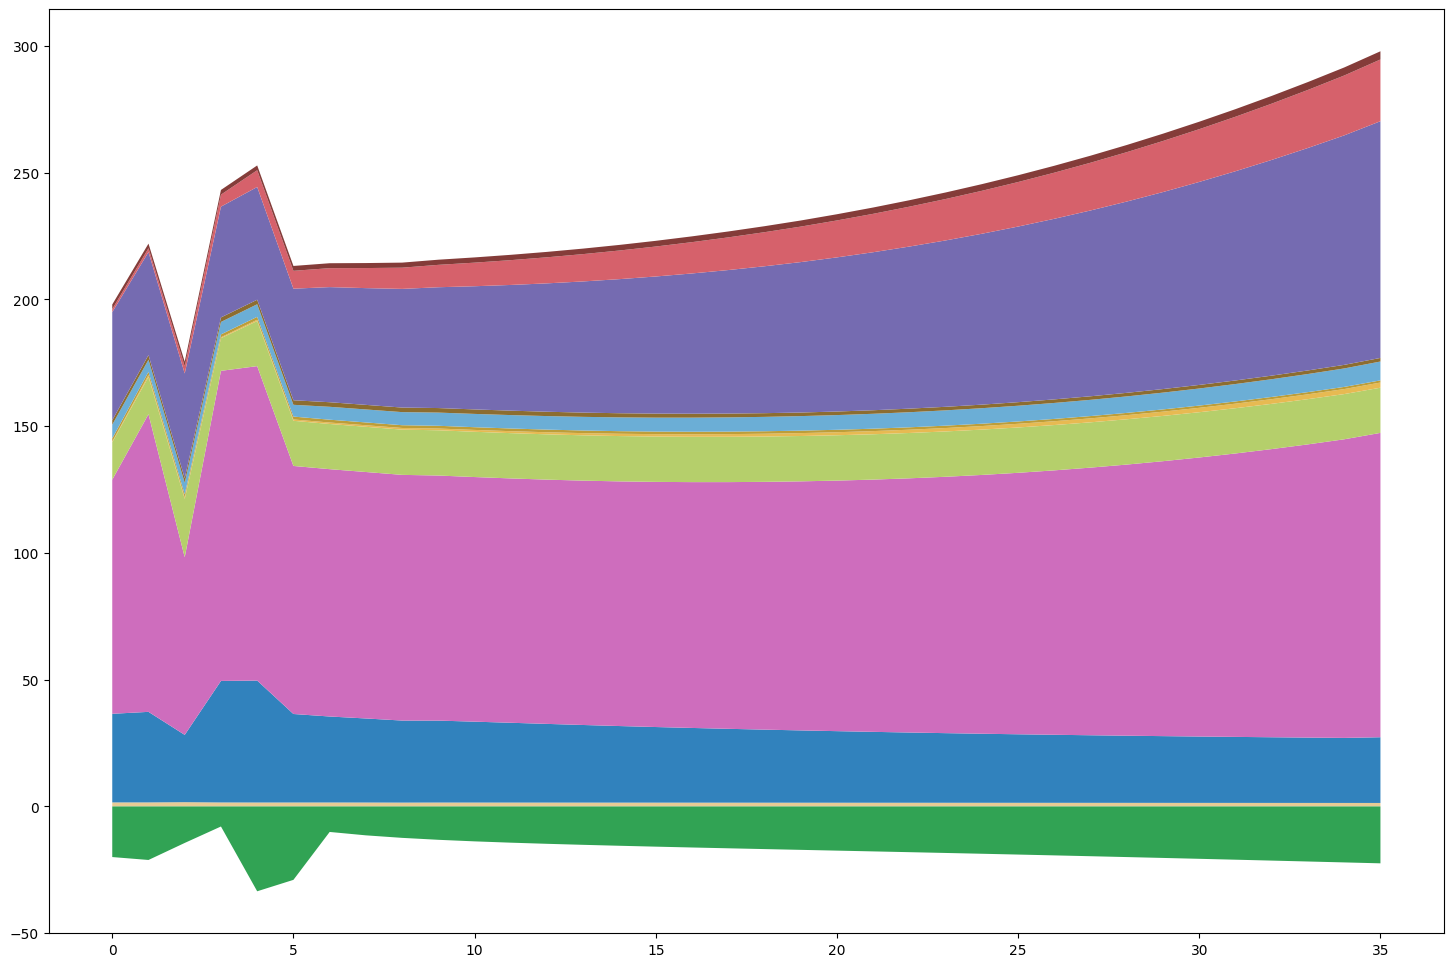

In [142]:
import sisepuede.plotting.plots as spp
df_in = df_inputs_base_la.drop(columns = [regions.key])

df_out = ssp.models.project(
    df_in,
    include_electricity_in_energy = False,
    #models_run = ["af", "ce", "ip", ""]
)

spp.plot_emissions_stack(df_out, matt, )

In [46]:
strat_0 = strategies.get_strategy(0)
df_0 = strat_0()

strat_6004 = strategies.get_strategy(6004)
df_6004 = strat_6004()

strat_6006 = strategies.get_strategy(6006)
df_6006 = strat_6006()

In [445]:
cols = sorted(list(set(df_6004.columns)))

for x in cols:
    if df_6004[x].iloc[0] != df_6006[x].iloc[0]:
        print(x)

strategy_id


In [521]:
df_out_6006 = ssp.models.project(df_6006,)

2025-09-01 14:54:41,771 - INFO - Running AFOLU model
2025-09-01 14:54:42,689 - INFO - AFOLU model run successfully completed
2025-09-01 14:54:42,690 - INFO - Running CircularEconomy model
2025-09-01 14:54:42,760 - INFO - CircularEconomy model run successfully completed
2025-09-01 14:54:42,761 - INFO - Running IPPU model
2025-09-01 14:54:42,844 - INFO - IPPU model run successfully completed
2025-09-01 14:54:42,844 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-09-01 14:54:42,868 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-09-01 14:54:42,944 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-09-01 14:54:42,944 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
2025-09-01 14:54:43,006 - INFO - 	Path to temporary NemoMod database '/Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_interme

In [89]:
vir = transformers.vec_implementation_ramp

In [101]:
df_6006[[x for x in df_6006.columns if "entc_capital_cost" in x]]


for k in [
    "nemomod_entc_capital_cost_pp_solar_mm_usd_per_gw",
    "nemomod_entc_capital_cost_pp_wind_mm_usd_per_gw",
    
]

,nemomod_entc_capital_cost_fp_hydrogen_electrolysis_mm_usd_per_gw,nemomod_entc_capital_cost_fp_hydrogen_gasification_mm_usd_per_gw,nemomod_entc_capital_cost_fp_hydrogen_reformation_mm_usd_per_gw,nemomod_entc_capital_cost_pp_biogas_mm_usd_per_gw,nemomod_entc_capital_cost_pp_biomass_mm_usd_per_gw,nemomod_entc_capital_cost_pp_coal_ccs_mm_usd_per_gw,nemomod_entc_capital_cost_pp_coal_mm_usd_per_gw,nemomod_entc_capital_cost_pp_gas_ccs_mm_usd_per_gw,nemomod_entc_capital_cost_pp_gas_mm_usd_per_gw,nemomod_entc_capital_cost_pp_geothermal_mm_usd_per_gw,nemomod_entc_capital_cost_pp_hydropower_mm_usd_per_gw,nemomod_entc_capital_cost_pp_nuclear_mm_usd_per_gw,nemomod_entc_capital_cost_pp_ocean_mm_usd_per_gw,nemomod_entc_capital_cost_pp_oil_mm_usd_per_gw,nemomod_entc_capital_cost_pp_solar_mm_usd_per_gw,nemomod_entc_capital_cost_pp_waste_incineration_mm_usd_per_gw,nemomod_entc_capital_cost_pp_wind_mm_usd_per_gw,nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw,nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw,nemomod_entc_capital_cost_fp_natural_gas_liquefaction_mm_usd_per_gw
0,1200.0,800.0,800.0,2581.866715,1332.000000,6625.0,2664.0,2845.0,1108.0,11905.666667,2979.000000,5153.583333,30495.04196,1204.871134,1256.000000,3872.800073,3209.722222,0,1200,783.704221
1,1200.0,800.0,800.0,2581.866715,1332.000000,6625.0,2664.0,2845.0,1108.0,11905.666667,2979.000000,5153.583333,30495.04196,1204.871134,1256.000000,3872.800073,3209.722222,0,1200,783.704221
2,1200.0,800.0,800.0,2581.866715,1332.000000,6625.0,2664.0,2845.0,1108.0,11905.666667,2979.000000,5153.583333,30495.04196,1204.871134,1256.000000,3872.800073,3209.722222,0,1200,783.704221
3,1200.0,800.0,800.0,2581.866715,1332.000000,6625.0,2664.0,2845.0,1108.0,11905.666667,2979.000000,5153.583333,30495.04196,1204.871134,1256.000000,3872.800073,3209.722222,0,1200,783.704221
4,1200.0,800.0,800.0,2581.866715,1332.000000,6625.0,2664.0,2845.0,1108.0,11905.666667,2979.000000,5153.583333,30495.04196,1204.871134,1256.000000,3872.800073,3209.722222,0,1200,783.704221
5,1200.0,800.0,800.0,2581.866715,1332.000000,6625.0,2664.0,2845.0,1108.0,11905.666667,2979.000000,5153.583333,30495.04196,1204.871134,1256.000000,3872.800073,3209.722222,0,1200,783.704221
6,1200.0,800.0,800.0,2581.866715,6478.122862,6625.0,2664.0,2845.0,1108.0,11368.025856,3237.780352,5153.583333,30495.04196,1204.871134,939.802849,3872.800073,2435.641791,0,1200,783.704221
7,1200.0,800.0,800.0,2581.866715,6330.162331,6625.0,2664.0,2845.0,1108.0,11108.379786,3163.829346,5153.583333,30495.04196,1204.871134,918.337722,3872.800073,2380.011656,0,1200,783.704221
8,1200.0,800.0,800.0,2581.866715,6185.581224,6625.0,2664.0,2845.0,1108.0,10854.664041,3091.567384,5153.583333,30495.04196,1204.871134,897.362859,3872.800073,2325.652115,0,1200,783.704221
9,1200.0,800.0,800.0,2581.866715,6044.302353,6625.0,2664.0,2845.0,1108.0,10606.743172,3020.955887,5153.583333,30495.04196,1204.871134,876.867063,3872.800073,2272.534147,0,1200,783.704221


In [96]:
df_6006[[x for x in df_6006.columns if "cost_enfu" in x]]
df_6006_try = df_6006.copy()

vir = sf.ramp_vector(
    df_6006.shape[0],
    r_0 = 10,
    r_1 = 25,
)

for k in [
    "cost_enfu_fuel_coal_usd_per_tonne",
    "cost_enfu_fuel_coke_usd_per_tonne",
    "cost_enfu_fuel_biogas_usd_per_mmbtu",
    "cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu",
    "cost_enfu_fuel_natural_gas_usd_per_mmbtu",
    "cost_enfu_fuel_crude_usd_per_m3",
    "cost_enfu_fuel_diesel_usd_per_m3",
    "cost_enfu_fuel_gasoline_usd_per_m3",
    "cost_enfu_fuel_kerosene_usd_per_m3",
    "cost_enfu_fuel_oil_usd_per_m3"
]:
    alpha = 0.5
    vals = df_6006_try[k].to_numpy().copy()
    vals_new = (1 - vir)*vals + vir*vals*alpha # = vals - (1 - alpha)*vir*vals

    df_6006_try[k] = vals

df_evaluate = ssp.models(df_6006_try)


2025-09-01 21:58:56,203 - INFO - Running AFOLU model
2025-09-01 21:58:56,509 - INFO - AFOLU model run successfully completed
2025-09-01 21:58:56,509 - INFO - Running CircularEconomy model
2025-09-01 21:58:56,536 - INFO - CircularEconomy model run successfully completed
2025-09-01 21:58:56,536 - INFO - Running IPPU model
2025-09-01 21:58:56,576 - INFO - IPPU model run successfully completed
2025-09-01 21:58:56,576 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-09-01 21:58:56,587 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-09-01 21:58:56,635 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-09-01 21:58:56,635 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-01-Sep 21:58:57.227 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-09-01 22:00:18,100 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-09-01 22:00:18,107 - INFO - EnergyProduction model run successfully completed
2025-09-01 22:00:18,108 - INFO - Running Energy (Fugitive Emissions)
2025-09-01 22:00:18,130 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-09-01 22:00:18,130 - INFO - Appending Socioeconomic outputs
2025-09-01 22:00:18,136 - INFO - Socioeconomic outputs successfully appended.


2025-01-Sep 22:00:18.009 Finished modeling scenario.


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

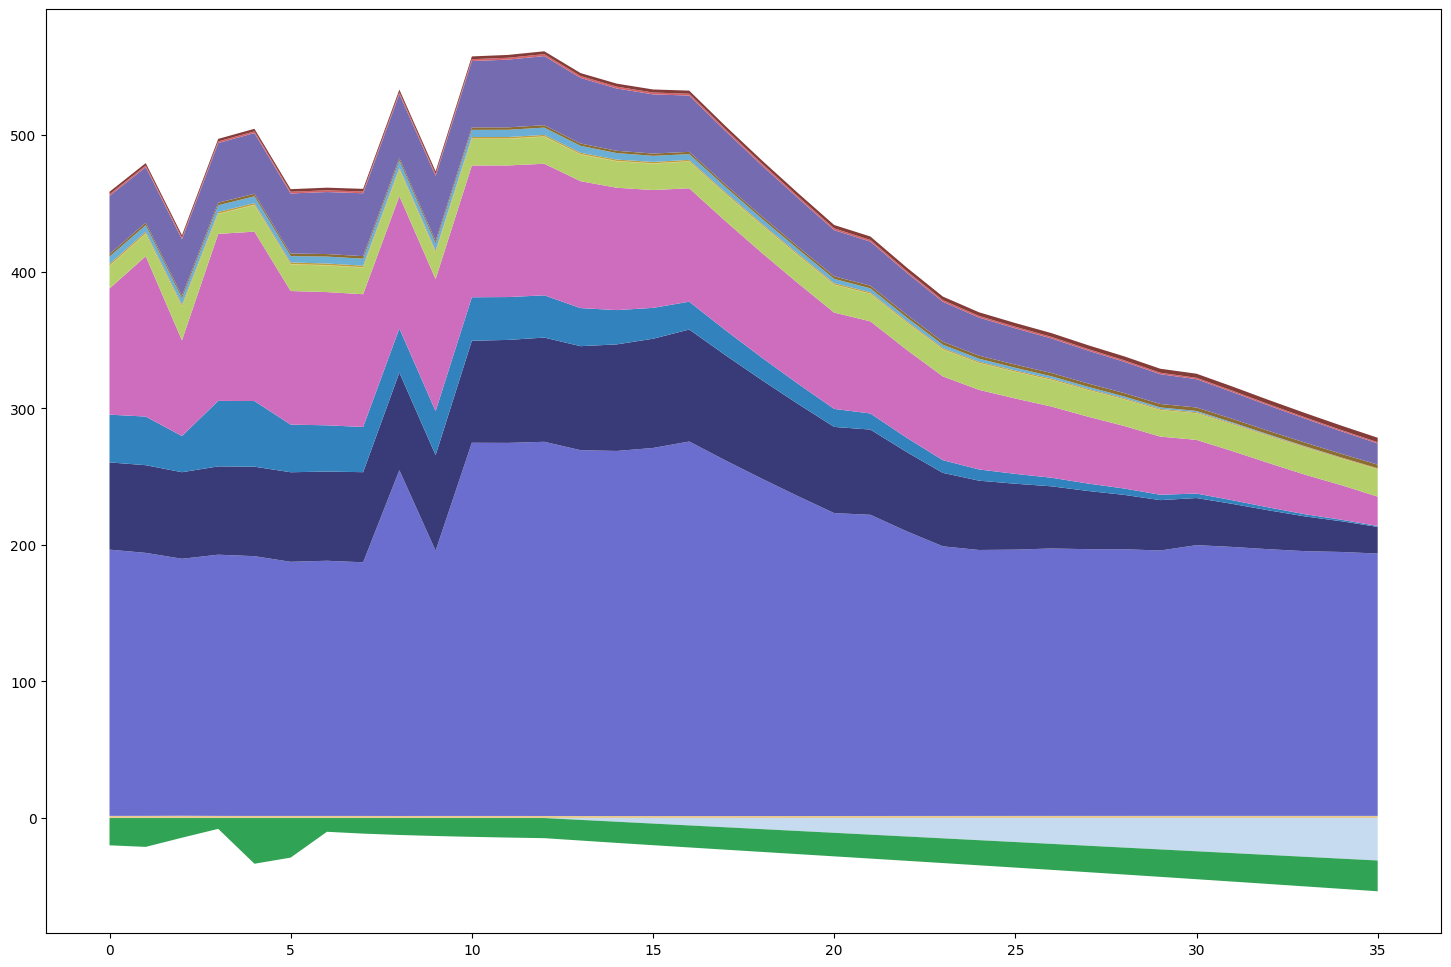

In [98]:
spp.plot_emissions_stack(df_evaluate, matt, )

### START TROUBLESHOOTING

In [70]:
fields_compare = [
    x for x in df_6006.columns 
    if True
    and ("frac_inen_energy" in x)
    and ("plastic" in x) 
    and ("recycled" not in x)
]
df_6006[fields_compare].tail()

,frac_inen_energy_plastic_coal,frac_inen_energy_plastic_coke,frac_inen_energy_plastic_diesel,frac_inen_energy_plastic_electricity,frac_inen_energy_plastic_furnace_gas,frac_inen_energy_plastic_gasoline,frac_inen_energy_plastic_hydrocarbon_gas_liquids,frac_inen_energy_plastic_hydrogen,frac_inen_energy_plastic_kerosene,frac_inen_energy_plastic_natural_gas,frac_inen_energy_plastic_oil,frac_inen_energy_plastic_solar,frac_inen_energy_plastic_solid_biomass
31,0.0,0.0,0.0,0.904731,0.0,0.0,0.0,0.0,0.0,0.095269,0.0,0.0,0.0
32,0.0,0.0,0.0,0.927459,0.0,0.0,0.0,0.0,0.0,0.072541,0.0,0.0,0.0
33,0.0,0.0,0.0,0.950887,0.0,0.0,0.0,0.0,0.0,0.049113,0.0,0.0,0.0
34,0.0,0.0,0.0,0.975054,0.0,0.0,0.0,0.0,0.0,0.024946,0.0,0.0,0.0
35,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [71]:
df_0[fields_compare].tail()


,frac_inen_energy_plastic_coal,frac_inen_energy_plastic_coke,frac_inen_energy_plastic_diesel,frac_inen_energy_plastic_electricity,frac_inen_energy_plastic_furnace_gas,frac_inen_energy_plastic_gasoline,frac_inen_energy_plastic_hydrocarbon_gas_liquids,frac_inen_energy_plastic_hydrogen,frac_inen_energy_plastic_kerosene,frac_inen_energy_plastic_natural_gas,frac_inen_energy_plastic_oil,frac_inen_energy_plastic_solar,frac_inen_energy_plastic_solid_biomass
31,0.0,0.0,0.0,0.452203,0.0,0.0,0.0,0.0,0.0,0.547797,0.0,0.0,0.0
32,0.0,0.0,0.0,0.443854,0.0,0.0,0.0,0.0,0.0,0.556146,0.0,0.0,0.0
33,0.0,0.0,0.0,0.435206,0.0,0.0,0.0,0.0,0.0,0.564794,0.0,0.0,0.0
34,0.0,0.0,0.0,0.426244,0.0,0.0,0.0,0.0,0.0,0.573756,0.0,0.0,0.0
35,0.0,0.0,0.0,0.416950,0.0,0.0,0.0,0.0,0.0,0.583050,0.0,0.0,0.0


In [73]:
df_out[[x for x in df_out.columns if ("emission_co2e_co2" in x) and ("plastic" in x)]]

,emission_co2e_co2_inen_plastic,emission_co2e_co2_inen_recycled_plastic,emission_co2e_co2_ippu_production_plastic
0,1.361754,0.0,21.294033
1,1.523265,0.0,23.758055
2,0.688744,0.0,10.858371
3,1.337250,0.0,22.205589
4,1.587090,0.0,25.179738
...,...,...,...
67,0.859804,0.0,26.710503
68,0.840174,0.0,27.049250
69,0.821210,0.0,27.412657
70,0.802841,0.0,27.801029


In [10]:
dict_scens = {
    # we exclude future because we will run across all futures
    # ssp.key_design: [0],
    #ssp.key_future: [0],
    #ssp.key_strategy: [0] + list(range(6004, 6015)),
    ssp.key_primary: [
        # low
        #402402,
        #404404,
        #
        # high:
        #404930,
        #404936
        405329,
        404942
    ]
}


ssp.project_scenarios(
    dict_scens,
    check_results = False,
    save_inputs = True,
)


2025-09-01 18:40:21,391 - INFO - 
***	STARTING REGION louisiana	***

2025-09-01 18:40:22,424 - INFO - Trying run primary_id = 404942 in region louisiana
2025-09-01 18:40:22,425 - INFO - Running AFOLU model
2025-09-01 18:40:22,702 - INFO - AFOLU model run successfully completed
2025-09-01 18:40:22,703 - INFO - Running CircularEconomy model
2025-09-01 18:40:22,726 - INFO - CircularEconomy model run successfully completed
2025-09-01 18:40:22,726 - INFO - Running IPPU model
2025-09-01 18:40:22,765 - INFO - IPPU model run successfully completed
2025-09-01 18:40:22,765 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-09-01 18:40:22,775 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-09-01 18:40:22,825 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-09-01 18:40:22,825 - INFO - Running Energy model (Electricity and Fuel Productio

2025-01-Sep 18:40:23.181 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-01-Sep 18:40:23.322 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-01-Sep 18:40:30.408 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-09-01 18:42:02,571 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-09-01 18:42:02,580 - INFO - EnergyProduction model run successfully completed
2025-09-01 18:42:02,580 - INFO - Running Energy (Fugitive Emissions)
2025-09-01 18:42:02,602 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-09-01 18:42:02,603 - INFO - Appending Socioeconomic outputs
2025-09-01 18:42:02,607 - INFO - Socioeconomic outputs successfully appended.
2025-09-01 18:42:02,609 - INFO - Model run for primary_id = 404942 successfully completed in 100.18 seconds (n_tries = 1).


2025-01-Sep 18:42:02.456 Finished modeling scenario.


2025-09-01 18:42:03,607 - INFO - Trying run primary_id = 405329 in region louisiana
2025-09-01 18:42:03,607 - INFO - Running AFOLU model
2025-09-01 18:42:03,877 - INFO - AFOLU model run successfully completed
2025-09-01 18:42:03,877 - INFO - Running CircularEconomy model
2025-09-01 18:42:03,901 - INFO - CircularEconomy model run successfully completed
2025-09-01 18:42:03,902 - INFO - Running IPPU model
2025-09-01 18:42:03,941 - INFO - IPPU model run successfully completed
2025-09-01 18:42:03,941 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-09-01 18:42:03,952 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-09-01 18:42:03,998 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-09-01 18:42:03,999 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-01-Sep 18:42:04.640 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-09-01 18:43:30,069 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-09-01 18:43:30,079 - INFO - EnergyProduction model run successfully completed
2025-09-01 18:43:30,079 - INFO - Running Energy (Fugitive Emissions)
2025-09-01 18:43:30,100 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-09-01 18:43:30,101 - INFO - Appending Socioeconomic outputs
2025-09-01 18:43:30,106 - INFO - Socioeconomic outputs successfully appended.
2025-09-01 18:43:30,107 - INFO - Model run for primary_id = 405329 successfully completed in 86.5 seconds (n_tries = 1).
2025-09-01 18:43:30,110 - INFO - 
***	 REGION louisiana COMPLETE	***

2025-09-01 18:43:30,166 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sise

2025-01-Sep 18:43:29.973 Finished modeling scenario.


2025-09-01 18:43:30,238 - INFO - Table MODEL_INPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-09-01T18;38;54.123673/sisepuede_run_2025-09-01T18;38;54.123673_output_database/MODEL_INPUT.csv.


{'louisiana': [404942, 405329]}

In [463]:
ssp.odpt_primary.get_indexing_dataframe_from_primary_key([405329])

,primary_id,design_id,strategy_id,future_id
0,405329,4,6006,925


In [452]:
#ssp.generate_summary_files(None, export = True, )
dict_scens.get(ssp.key_primary)

[402402, 404404, 404930, 404936]

In [11]:
df_in = ssp.read_input(None)
df_out = ssp.read_output(None)

In [20]:
df_out["emission_co2e_subsector_total_entc"]

0     194.940526
1     192.556441
2     188.150486
3     191.244203
4     190.188775
         ...    
67    414.065001
68    417.395735
69    420.758375
70    424.155427
71    427.563899
Name: emission_co2e_subsector_total_entc, Length: 72, dtype: float64

In [24]:
df_out[
        df_out[ssp.key_primary].isin([404942])#405329])
    ]["emission_co2e_subsector_total_frst"]

0    -19.958559
1    -21.109438
2    -14.394049
3     -7.905364
4    -33.457072
5    -28.953986
6    -10.056567
7    -11.387871
8    -12.368511
9    -13.120219
10   -13.721483
11   -14.221867
12   -14.653925
13   -15.020574
14   -15.392233
15   -15.698409
16   -15.988709
17   -16.266316
18   -16.531715
19   -16.790333
20   -17.045466
21   -17.298157
22   -17.551342
23   -17.807239
24   -18.066770
25   -18.331690
26   -18.603333
27   -18.882612
28   -19.170489
29   -19.467240
30   -19.772765
31   -20.086495
32   -20.407692
33   -20.736392
34   -21.071602
35   -21.412591
Name: emission_co2e_subsector_total_frst, dtype: float64

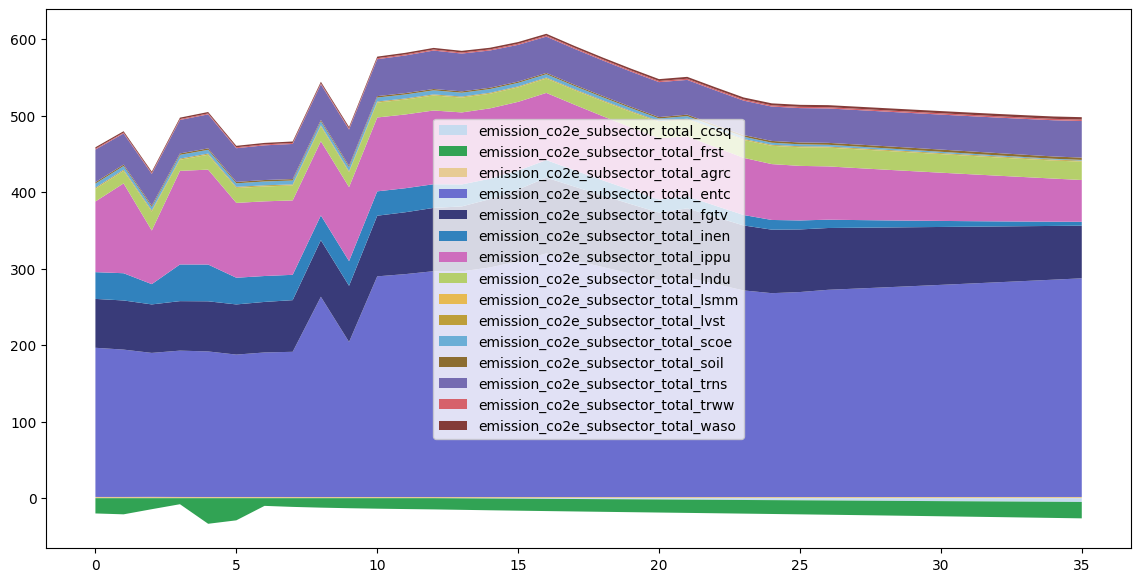

In [21]:
fig, ax = plt.subplots(figsize = (14, 7))

spp.plot_emissions_stack(
    df_out[
        df_out[ssp.key_primary].isin([404942])#405329])
    ],
    matt,
    figtuple = (fig, ax),
)

ax.legend()

2025-09-01 20:22:44,662 - INFO - Running AFOLU model
2025-09-01 20:22:44,959 - INFO - AFOLU model run successfully completed
2025-09-01 20:22:44,960 - INFO - Running CircularEconomy model
2025-09-01 20:22:44,984 - INFO - CircularEconomy model run successfully completed
2025-09-01 20:22:44,985 - INFO - Running IPPU model
2025-09-01 20:22:45,025 - INFO - IPPU model run successfully completed
2025-09-01 20:22:45,025 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-09-01 20:22:45,036 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-09-01 20:22:45,083 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-09-01 20:22:45,083 - INFO - Running Energy (Fugitive Emissions)
2025-09-01 20:22:45,096 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-09-01 20:22:45,096 - INFO - Appe

<Axes: >

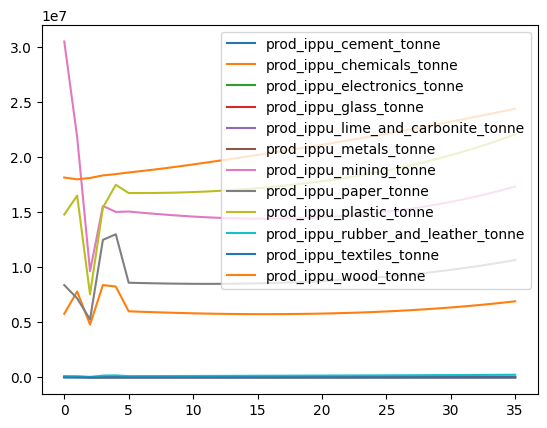

In [77]:
df_temp = ssp.models.project(
    df_0,
    include_electricity_in_energy = False,
)

modvar.get_from_dataframe(
    df_temp
).plot()

<Axes: >

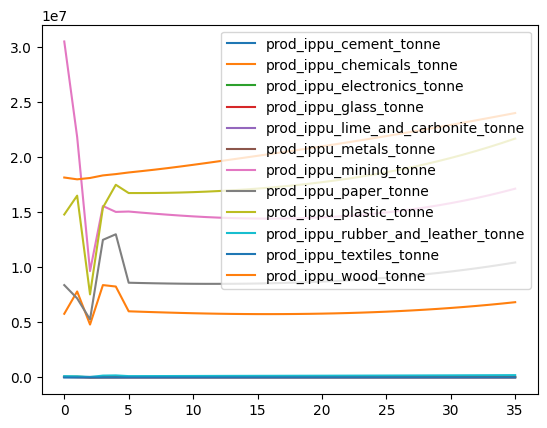

In [66]:
modvar = matt.get_variable("Industrial Production")
modvar.get_from_dataframe(
    df_out[
        df_out[ssp.key_primary].isin([404942])#405329])
    ]
).plot()

In [202]:
df_tmp = pd.read_csv("/Users/usuario/Documents/aws_sisepuede/tmp_data.csv")
cols_ordered = list(df_tmp.columns)

In [204]:
(
    df_out[
        df_out["primary_id"].isin([0])
    ][cols_ordered]
    .reset_index(drop = True, )
    .to_csv(
        "/Users/usuario/Documents/aws_sisepuede/upload_output.csv",
        index = None,
        encoding = "UTF-8",
    )
)

In [225]:
strategies.attribute_table.table.iloc[-14:]

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
69,6003,PFLO:ALL_WITH_ENFU_EXPORT_INCREASE,All Actions without decreasing exports or dema...,All actions (unique by transformer) with incre...,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
70,6004,PFLO:ALL_LA_ACTIONS,All Louisiana Actions,All actions evaluated in the Louisiana context,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
71,6005,PFLO:ALL_LA_ACTIONS_MEDIUM_INTENSITY,All Louisiana Actions at medium (approx 50%) i...,"Includes all actions evaluate in LEAP, but wit...",TX:AGRC:DEC_CH4_RICE_MIDINTENS|TX:AGRC:DEC_LOS...,0
72,6006,PFLO:ALL_LA_ACTIONS_LC,All Louisiana Actions with Least Cost Solution...,All actions evaluated in the Louisiana context...,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
73,6007,PFLO:ALL_LA_ACTIONS_LC_MEDIUM_INTENSITY,All Louisiana Actions with Least Cost Solution...,Includes all actions evaluate in LEAP except f...,TX:AGRC:DEC_CH4_RICE_MIDINTENS|TX:AGRC:DEC_LOS...,0
74,6008,PFLO:TWI_ELECTRIC_POWER_95,TWI energy Subsector Electric Power 95,Defined by TWI 20250814 - TWI energy Subsector...,TX:ENTC:DEC_LOSSES|TX:ENTC:TARGET_RENEWABLE_ELEC,0
75,6009,PFLO:TWI_ELECTRIC_POWER_LC,TWI energy Subsector Electric Power LC,Defined by TWI 20250814 - TWI energy Subsector...,TX:ENTC:LEAST_COST_SOLUTION,0
76,6010,PFLO:TWI_ELECTRIC_POWER_EFFICIENCY,TWI energy Subsector Electric Power Efficiency,Defined by TWI 20250814 - TWI energy Subsector...,TX:ENTC:DEC_LOSSES,0
77,6011,PFLO:TWI_INDUSTRY,TWI energy Subsector Industry,Defined by TWI 20250814 - TWI energy Subsector...,TX:CCSQ:INC_CAPTURE|TX:ENTC:TARGET_CLEAN_HYDRO...,0
78,6012,PFLO:TWI_INDUSTRIAL_EFFICIENCY,TWI energy Subsector Industrial Efficiency,Defined by TWI 20250814 - TWI energy Subsector...,TX:INEN:INC_EFFICIENCY_ENERGY|TX:INEN:INC_EFFI...,0


In [222]:
ssp.odpt_primary.get_indexing_dataframe(df_out["primary_id"].unique())

,primary_id,design_id,strategy_id,future_id
0,0,0,0,0
1,70070,0,6004,0
2,71071,0,6005,0
3,72072,0,6006,0
4,73073,0,6007,0
5,74074,0,6008,0
6,75075,0,6009,0
7,76076,0,6010,0
8,77077,0,6011,0
9,78078,0,6012,0


In [357]:

"""flds = [
    x for x in df_tmp.columns 
    if True
    and ("frac_trns" in x)
    and ("water_borne" in x)
]
df_tmp[flds].sum(axis = 1)
"""


df_tmp0 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_ENERGIA_21.csv")
df_tmp1 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_AFOLU_2.csv")
df_tmp2 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_Desechos_2.csv")
df_tmp3 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_PIUP_2.csv")
df_tmp4 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_Socie_2.csv")

df = pd.concat(
    [
        #df_tmp0,
        df_tmp1,
        df_tmp2, 
        df_tmp3,
        df_tmp4
    ],
    axis = 1,
)

df_example = examples.input_data_frame.copy()
fields_missing = [x for x in df_example.columns if x not in df.columns]
df = pd.concat(
    [
        df_example[fields_missing],
        df
    ],
    axis = 1,
)









In [368]:
df_out2[[x for x in df_out2.columns if ("emission_co2e" in x) and ("ippu" in x)]].iloc[0:1].transpose().sort_values(by = 0)






,0
emission_co2e_c2f6_ippu_product_use_product_use_ods_other,0.000000
emission_co2e_cf4_ippu_product_use_product_use_ods_other,0.000000
emission_co2e_hfcs_ippu_production_metals,0.000000
emission_co2e_cf4_ippu_production_electronics,0.000000
emission_co2e_hfcs_ippu_production_electronics,0.000000
...,...
emission_co2e_pfcs_ippu_production_chemicals,282.847653
emission_co2e_hfcs_ippu_production_chemicals,305.412064
emission_co2e_c2f6_ippu_production_metals,3846.504212
emission_co2e_cf4_ippu_production_metals,8241.445476


In [391]:
# df[[x for x in df.columns if "lvst" in x and "_n" in x]].iloc[0]
# 0.2/(1000*matt.get_gwp("c2f6"))
# df_example["ef_ippu_tonne_cf4_per_tonne_production_metals"]

In [413]:
df_example[[x for x in df_example.columns if ("enfu" in x) and ("cost" in x)]].iloc[0]


cost_enfu_fuel_biofuels_usd_per_m3                      3.163583e+01
cost_enfu_fuel_biogas_usd_per_mmbtu                     2.200000e+01
cost_enfu_fuel_biomass_usd_per_tonne                    2.097800e+02
cost_enfu_fuel_coal_usd_per_tonne                       1.048892e+02
cost_enfu_fuel_coke_usd_per_tonne                       1.877075e+02
cost_enfu_fuel_crude_usd_per_m3                         3.673626e+02
cost_enfu_fuel_diesel_usd_per_m3                        1.432857e+03
cost_enfu_fuel_electricity_usd_per_mmbtu                7.550796e+01
cost_enfu_fuel_furnace_gas_usd_per_m3                   8.907000e+04
cost_enfu_fuel_gasoline_usd_per_m3                      1.788571e+03
cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu    1.616651e+02
cost_enfu_fuel_hydrogen_usd_per_mmbtu                   1.044513e+02
cost_enfu_fuel_kerosene_usd_per_m3                      2.169214e+01
cost_enfu_fuel_natural_gas_usd_per_mmbtu                6.239752e+00
cost_enfu_fuel_nuclear_usd_per_ton

In [410]:
df_out2[[x for x in df_out.columns if ("metals" in x)]].iloc[0]


emission_co2e_c2f6_ippu_production_metals            3.846504e+03
emission_co2e_cf4_ippu_production_metals             8.241445e+03
emission_co2e_ch4_ippu_production_metals             3.029122e-03
emission_co2e_co2_ippu_production_metals             1.085707e+00
emission_co2e_hfcs_ippu_production_metals            0.000000e+00
emission_co2e_sf6_ippu_production_metals             0.000000e+00
gasrecovered_ippu_mt_co2_capture_metals              0.000000e+00
net_imports_change_ippu_recycled_metals_tonne        0.000000e+00
prod_ippu_metals_tonne                               1.551010e+06
qty_ippu_recycled_metals_used_in_production_tonne    1.425204e+03
Name: 0, dtype: float64

In [407]:
df_input["consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing"]

0     1.017079
1     1.112163
2     1.132271
3     1.141771
4     1.144099
5     1.256018
6     1.256018
7     1.256018
8     1.256018
9     1.256018
10    1.256018
11    1.256018
12    1.256018
13    1.256018
14    1.256018
15    1.256018
16    1.256018
17    1.256018
18    1.256018
19    1.256018
20    1.256018
21    1.256018
22    1.256018
23    1.256018
24    1.256018
25    1.256018
26    1.256018
27    1.256018
28    1.256018
29    1.256018
30    1.256018
31    1.256018
32    1.256018
33    1.256018
34    1.256018
35    1.256018
Name: consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing, dtype: float64

In [427]:
for k in [x for x in matt.all_variable_fields_output if ("enfu" in x)]:
    print(k)



energy_demand_enfu_subsector_total_pj_ccsq_fuel_biofuels
energy_demand_enfu_subsector_total_pj_ccsq_fuel_biogas
energy_demand_enfu_subsector_total_pj_ccsq_fuel_biomass
energy_demand_enfu_subsector_total_pj_ccsq_fuel_coal
energy_demand_enfu_subsector_total_pj_ccsq_fuel_coke
energy_demand_enfu_subsector_total_pj_ccsq_fuel_crude
energy_demand_enfu_subsector_total_pj_ccsq_fuel_diesel
energy_demand_enfu_subsector_total_pj_ccsq_fuel_electricity
energy_demand_enfu_subsector_total_pj_ccsq_fuel_furnace_gas
energy_demand_enfu_subsector_total_pj_ccsq_fuel_gasoline
energy_demand_enfu_subsector_total_pj_ccsq_fuel_geothermal
energy_demand_enfu_subsector_total_pj_ccsq_fuel_hydrocarbon_gas_liquids
energy_demand_enfu_subsector_total_pj_ccsq_fuel_hydrogen
energy_demand_enfu_subsector_total_pj_ccsq_fuel_kerosene
energy_demand_enfu_subsector_total_pj_ccsq_fuel_natural_gas
energy_demand_enfu_subsector_total_pj_ccsq_fuel_nuclear
energy_demand_enfu_subsector_total_pj_ccsq_fuel_ocean
energy_demand_enfu_subsec

2025-08-29 15:24:31,937 - INFO - Running AFOLU model
2025-08-29 15:24:32,254 - INFO - AFOLU model run successfully completed
2025-08-29 15:24:32,255 - INFO - Running CircularEconomy model
2025-08-29 15:24:32,292 - INFO - CircularEconomy model run successfully completed
2025-08-29 15:24:32,293 - INFO - Running IPPU model
2025-08-29 15:24:32,340 - INFO - IPPU model run successfully completed
2025-08-29 15:24:32,341 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-29 15:24:32,353 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-29 15:24:32,409 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-29 15:24:32,409 - INFO - Running Energy (Fugitive Emissions)
2025-08-29 15:24:32,425 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-29 15:24:32,425 - INFO - Appe

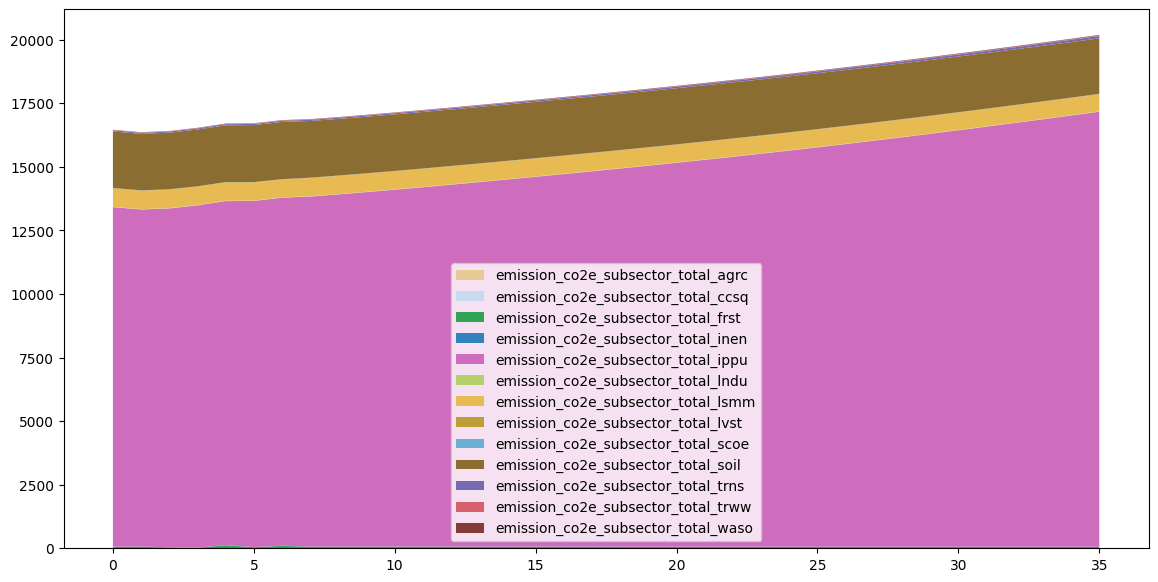

In [362]:
df_out2 = ssp.models.project(
    df,
    include_electricity_in_energy = False,
    
)

fig, ax = plt.subplots(figsize = (14, 7))

spp.plot_emissions_stack(
    df_out2,
    matt,
    figtuple = (fig, ax)
)

ax.legend()

In [356]:
import sisepuede.models.energy_consumption as ec

def get_all_trns_fields_from_subset(
    df_in: pd.DataFrame, 
    model_attributes: 'ModelAttributes',
) -> pd.DataFrame:
    """Using a DataFrame df_in that only has fuel mix fractions
        for SOME fuels for each transportation category, extract
        any remaining fuels.
    """
    df_transporation_frac = []
    model_enercons = ec.EnergyConsumption(model_attributes) #model_enercons
    modvars = model_enercons.modvars_trns_list_fuel_fraction
    attr_trns = model_attributes.get_attribute_table("Transportation")


    # order output fields
    fields_ext = []
    for cat in attr_trns.key_values:
    

        for modvar in modvars:
            modvar = matt.get_variable(modvar)
            if cat not in modvar.dict_category_keys.get("cat_transportation"):
                continue
    
            field = modvar.build_fields(category_restrictions = cat, )
            fields_ext.append(field)
    
        """
        max_dev = np.abs(vec - 1).max()
        if max_dev > 0.00000001:
            print(fields)
            print(f"{cat}:\t\t{vec.max()}")
        """

    
    for modvar in modvars:
        modvar = model_attributes.get_variable(modvar)
        try:
            out = model_attributes.extract_model_variable(
                df_in,
                modvar,
                all_cats_missing_val = 0.0,
                extraction_logic = "any_fill",
            )

        except:
            out = modvar.spawn_default_dataframe(
                length = df_in.shape[0],
            )

        df_transporation_frac.append(out, )

    df_transporation_frac = (
        pd.concat(
            df_transporation_frac,
            axis = 1
        )
        .get(fields_ext)
    )

    return df_transporation_frac

df_all_trns_frac_vars = = get_all_trns_fields_from_subset(
    df_tmp0, # YOUR ENERGY DATA
    matt,    # MODEL ATTRIBUTES
)

In [359]:
22

22

In [233]:
flds = matt.get_all_subsector_emission_total_fields()

<Axes: >

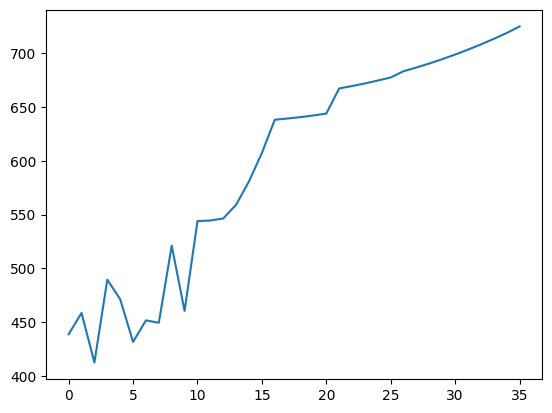

In [238]:

# df_out[df_out["primary_id"].isin([0])][flds].sum(axis = 1).plot()



(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

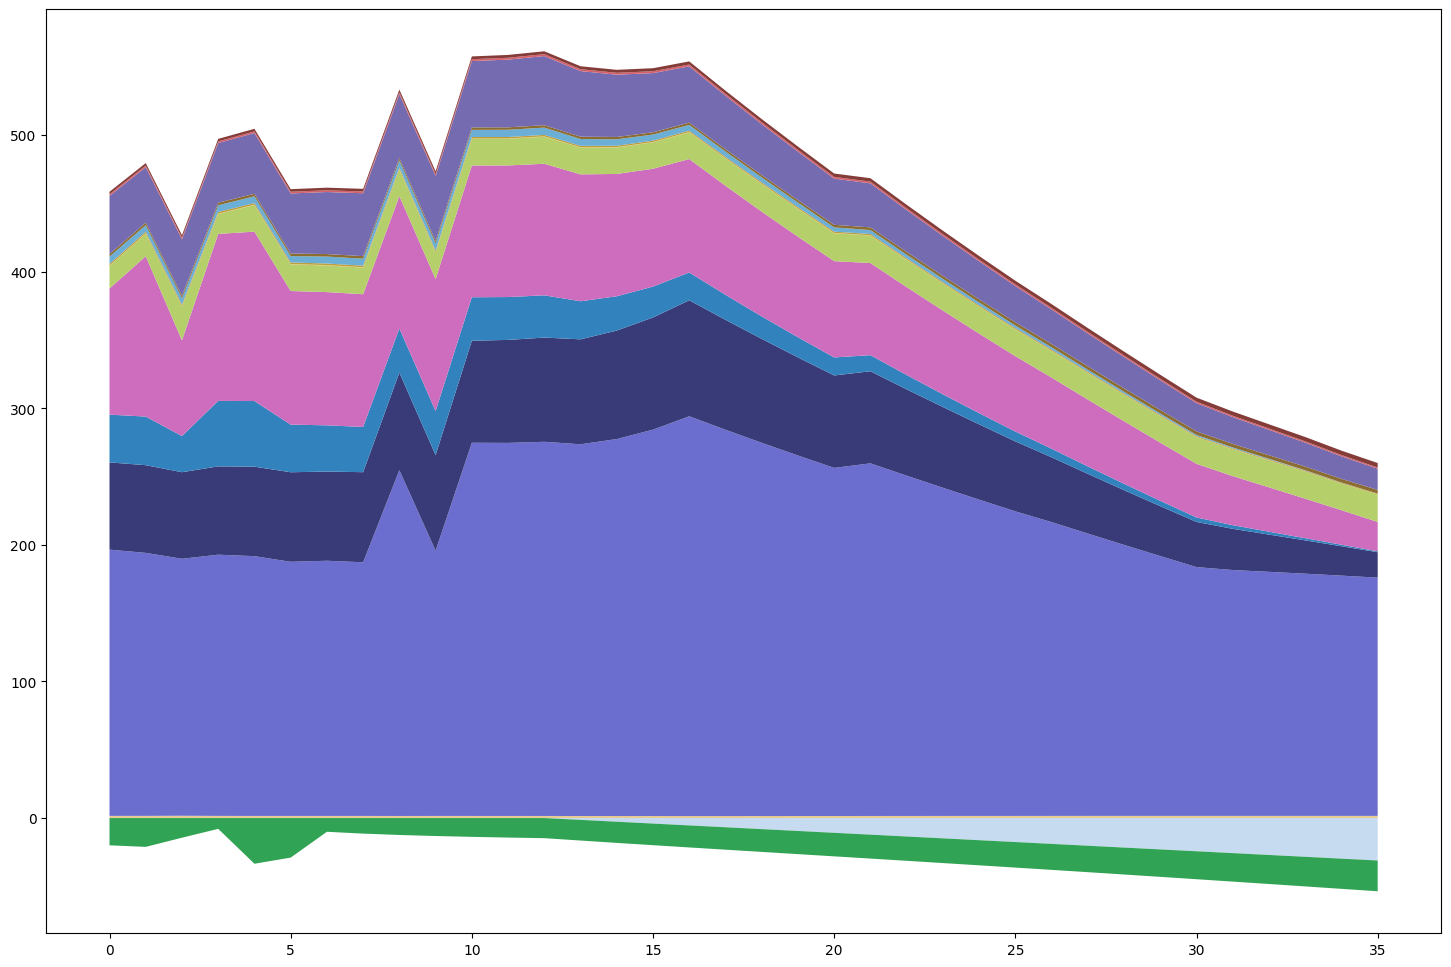

In [228]:
import sisepuede.plotting.plots as spp
spp.plot_emissions_stack(
    df_out[df_out["primary_id"].isin([70070])],
    matt,
)

# Finally, we can export a summary file

In [197]:
df_tmp.columns

False

In [199]:
df_in[cols_ordered]

,primary_id,region,time_period,area_gnrl_country_ha,area_lndu_infimum_croplands_ha,area_lndu_infimum_flooded_ha,area_lndu_infimum_forests_mangroves_ha,area_lndu_infimum_forests_primary_ha,area_lndu_infimum_forests_secondary_ha,area_lndu_infimum_grasslands_ha,...,yf_agrc_herbs_and_other_perennial_crops_tonne_ha,yf_agrc_nuts_tonne_ha,yf_agrc_other_annual_tonne_ha,yf_agrc_other_woody_perennial_tonne_ha,yf_agrc_pulses_tonne_ha,yf_agrc_rice_tonne_ha,yf_agrc_sugar_cane_tonne_ha,yf_agrc_tubers_tonne_ha,yf_agrc_vegetables_and_vines_tonne_ha,yf_lndu_supremum_pastures_tonne_per_ha
0,0,louisiana,0,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.059233,2.946800,6.177415,0.0,2.755621,8.636027,73.140598,37.547100,28.821448,92.81
1,0,louisiana,1,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.539800,3.455483,7.165802,0.0,3.259699,8.228317,71.163825,39.000100,29.765171,92.81
2,0,louisiana,2,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.161233,3.041817,11.119348,0.0,3.958685,8.302446,89.448975,39.119475,28.720595,92.81
3,0,louisiana,3,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.289167,3.375283,5.436126,0.0,4.167037,8.846059,90.190264,37.352525,29.482348,92.81
4,0,louisiana,4,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.337700,2.992183,6.177415,0.0,3.226093,7.882382,84.012849,38.551850,32.769776,92.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,80080,louisiana,31,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
428,80080,louisiana,32,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
429,80080,louisiana,33,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
430,80080,louisiana,34,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
